In [1]:
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt

## 导入数据集

In [2]:
def loadSimpData():
    datMat = matrix([[1. , 2.1],
                    [2. , 1.1],
                    [1.3, 1. ],
                    [1. ,1. ],
                    [2. ,1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

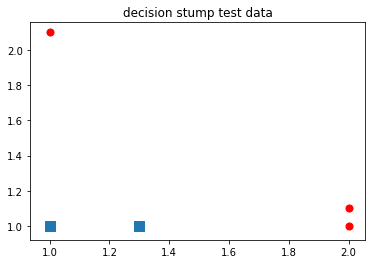

In [3]:
def plotDataSet(datMat,classLabels):
    xcord0 = []
    ycord0 = []
    xcord1 = []
    ycord1 = []
    markers =[]
    colors =[]

    for i in range(len(classLabels)):
        if classLabels[i]==1.0:
            xcord1.append(datMat[i,0]), ycord1.append(datMat[i,1])
        else:
            xcord0.append(datMat[i,0]), ycord0.append(datMat[i,1])
    fig = plt.figure()
    ax = fig.add_subplot(111)       
    ax.scatter(xcord0,ycord0, marker='s', s=90)
    ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
    plt.title('decision stump test data')
    plt.show()

datMat,classLabels = loadSimpData()
plotDataSet(datMat,classLabels)

## 生成单层决策树
1. 第一个函数用于测试是否有某个值小于或者大于我们正在测的阈值
2. 第二个函数会在一个加权数据集中循环，并找到具有最低错误率的单层决策树

    * 将最小错误率minError设为正无穷大
    * 对数据集中的每一个特征（第一层循环）：
        * 对每个步长（第二次循环，用于确定阈值）:
            * 对每个不等号：
                * 建立一棵单层决策树并利用加权数据集及对它进行测试
                * 如果错误率低于minError，则将当前单层决策树设为最佳单层决策树
    * 返回最佳单层决策树

In [50]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    '''通过阈值比较对数据进行分类，所有不满足不等式的都被设置为-1，其他的被设置为1'''
    
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0

    return retArray

In [77]:
def buildStump(dataArr,classLabels,D):
    '''遍历stumpClassify()函数所有的可能输入值，并找到数据集上最佳的单层决策树。'''
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T                #输入数据集 M * N ，标签 M * 1
    m,n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))        #设定步长调整的次数，建立用于存储最好决策树的字典，最好分类预测结果
    minError = inf                                                          #初始化最小误差为无穷大
    
    for i in range(n):
        '''在数据集的所有特征上遍历'''
        rangeMin = dataMatrix[:,i].min();rangeMax = dataMatrix[:,i].max()    #计算每一个特征的最小值和最大值
        stepSize = (rangeMax-rangeMin)/numSteps                              #计算最大步长
        
        for j in range(-1,int(numSteps)+1): 
            '''调整阈值'''
            for inequal in ['lt','gt']:
                threshVal = (rangeMin+float(j)*stepSize)                         #计算阈值
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)    #根据维度和阈值，预测标签
                # print(predictedVals)

                errArr = mat(ones((m,1)))                                        #初始化误差矩阵为1，若预测和标签相等则设为0
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr                                       #计算加权错误率
                print('split dim: %d, %s than the thresh %.2f, the weighted error is %.3f' % (i, inequal,threshVal, weightedError))

                if weightedError<minError:                                       #找到使得加权错误率最小的阈值和维度
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['ineq'] = inequal
                    bestStump['thresh'] = threshVal
                
    return bestStump,minError,bestClasEst                                    #返回最好的树结构，最小的加权错误率和预测标签

In [78]:
datMat, classLabels = loadSimpData()
D = mat(ones((5,1))/5)
buildStump(datMat,classLabels,D)

split dim: 0, lt than the thresh 0.90, the weighted error is 0.400
split dim: 0, gt than the thresh 0.90, the weighted error is 0.600
split dim: 0, lt than the thresh 1.00, the weighted error is 0.400
split dim: 0, gt than the thresh 1.00, the weighted error is 0.600
split dim: 0, lt than the thresh 1.10, the weighted error is 0.400
split dim: 0, gt than the thresh 1.10, the weighted error is 0.600
split dim: 0, lt than the thresh 1.20, the weighted error is 0.400
split dim: 0, gt than the thresh 1.20, the weighted error is 0.600
split dim: 0, lt than the thresh 1.30, the weighted error is 0.200
split dim: 0, gt than the thresh 1.30, the weighted error is 0.800
split dim: 0, lt than the thresh 1.40, the weighted error is 0.200
split dim: 0, gt than the thresh 1.40, the weighted error is 0.800
split dim: 0, lt than the thresh 1.50, the weighted error is 0.200
split dim: 0, gt than the thresh 1.50, the weighted error is 0.800
split dim: 0, lt than the thresh 1.60, the weighted error is 0

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 完整AdaBoost 算法实现
伪代码
* 对每次迭代：
    * 利用 buildStump() 函数找到最佳的单层决策树
    * 将单层决策树加入到单层决策树数组
    * 计算 单层决策树分类器对应的权重alpha
    * 计算新的数据权重 D
    * 更新累计类别估计值
    * 如果错误率等于0，则退出循环   


In [55]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []                                                  # 初始化弱分类器数组
    m = shape(dataArr)[0];    D = mat(ones((m,1))/m)                   # 初始化数据权重
    aggClassEst = mat(zeros((m,1)))                                    # 初始化累计预测值
    
    for i in range(numIt):                                              
        bestStump, error, classEst = buildStump(dataArr,classLabels,D) # 找到加权误差率最小的的决策树
        # print('D:',D.T)
        # print('classEst',classEst.T)
        
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))           # 计算分类器权重           
        #print('alpha:',alpha)
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        
        
        expon = multiply(-1*alpha*mat(classLabels).T, classEst)        #  更新 数据权重 D = D * exp(-alpha * yi * G(xi)) / D.sum()
        D = multiply(D, exp(expon))
        D = D/D.sum()
        
        aggClassEst += alpha*classEst                                  # 累计预测值
        #print('aggClassEst:',aggClassEst.T)
        
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m,1)))
        errorRate = aggErrors.sum()/m                                  # 计算多个分类器组合之后的错误率
        print('total error:',errorRate)
        
        if errorRate == 0.0:
            break
            
    return weakClassArr         # 返回弱分类器数组

In [56]:
classifierArr = adaBoostTrainDS(datMat,classLabels,9)
print(classifierArr)

total error: 0.2
total error: 0.2
total error: 0.0
[{'dim': 0, 'ineq': 'lt', 'thresh': 1.3, 'alpha': 0.6931471805599453}, {'dim': 1, 'ineq': 'lt', 'thresh': 1.0, 'alpha': 0.9729550745276565}, {'dim': 0, 'ineq': 'lt', 'thresh': 0.9, 'alpha': 0.8958797346140273}]


## 利用训练好的 AdaBoost 分类器进行分类

In [81]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = mat(datToClass)
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst 
        #print('aggClassEst:',aggClassEst)
    
    return sign(aggClassEst)    

In [82]:
adaClassify([0,0],classifierArr)

matrix([[-1.]])

# 用 AdaBoost 算法预测患有疝病的马是否能够存活

### 导入数据集

In [63]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    datMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curline = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curline[i]))
        datMat.append(lineArr)
        labelMat.append(float(curline[-1]))
    return datMat, labelMat        

### 训练

In [65]:
datArr, labelArr = loadDataSet(r'data/horseColicTraining2.txt')
# print(labelArr)                                                 # 标签必须为 1.0 和 -1.0
weakclassEst = adaBoostTrainDS(datArr, labelArr,10)

total error: 0.2842809364548495
total error: 0.2842809364548495
total error: 0.24749163879598662
total error: 0.24749163879598662
total error: 0.25418060200668896
total error: 0.2408026755852843
total error: 0.2408026755852843
total error: 0.22073578595317725
total error: 0.24749163879598662
total error: 0.23076923076923078


In [79]:
### 测试

In [84]:
datArr, labelArr = loadDataSet(r'data/horseColicTest2.txt')
prediction = adaClassify(datArr, weakclassEst)
# print(prediction)
errArr = mat(ones((67,1)))
errArr[prediction != mat(labelArr).T].sum()

16.0

In [1]:
def plotROC(predStrengths, classLabels):
    cur = (1.0,1.0)
    ySum = 0.0
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas)
    xStep = 1/float(len(classLabels)-numPosClas)
    
    sortedIndicies = predStrengths.argsort()
    
    fig = plt.figure()
    fig.clf()
    
    ax = plt.subplot(111)
    for index in sortedIndicies.toList():
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep;delY = 0;
        ySum += cur[1]
        
        ax.plot([cur[0],cur[0]-delX], [cur[1], cur[1]-delY], c='b')
        cur = (curp[0]-delX, cur[1]-delY)
    
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False Positive'); plt.ylabel('True Positive')
    plt.title('ROC')
    ax.axis([0.1,0.1])
    plt.show()
    print('the Area Under the curve is:', ySum*xStep)
    